# Tutorial 2 - Exploring some options in the FingerPrint Class

In this tutorial we perform a similar calculation to that in Tutorial 1, but now discuss the methods used in further detail. 


### Step 1 --  Setting up the FingerPrint class

When setting up an instance of the ```FingerPrint``` class the following keyword arguments can be set:
- ```lmax```: The truncation degree for spherical harmonics used within the calculations. The default value is 256.
- ```earth_model_parameters```: An instance of the class ```EarthModelParameter``` that sets units for non-dimensionalisation along with values for various parameters for the earth model. The default is SI base units and values for Earth.
- ```rotational_feedbacks```: If ```True```, rotational feedbacks are included within the calculations. Default is ```True```.
- ```grid```: The form of the spatial grid chosen from the options for the ```pyshtools``` library. The default is ```"DH"``` which corresponds to the standard Driscoll-Healy grid.
- ```extend```: If ```True``` the spatial grid is extended to include longitude 360 as well as 0. Default is ```True```.
- ```love_number_file```: The path to the  Love number file. The default is to a file precalculated for PREM (Dziewonski & Anderson, 1981) with values up to degree 4096. 

For most users ```lmax``` will be the parameter of most interest, with this value controlling the spatial resolution of the calculations. 

In the example below we set up a ```FingerPrint``` instance using some non-default values. In particular, we set up a sensible non-dimensionalisation scheme for geophysical applications, we choose to work with a Gauss-Legendre grid instead of the default Driscoll-Healy one, and we set ```extend``` equal to false. 

In [1]:
# Import necessary modules for this notebook. 
import numpy as np
import matplotlib.pyplot as plt
from pyshtools import SHGrid
from pyslfp import FingerPrint,  EarthModelParamters




# Set up fingerprint based on a Gauss-Legendre quadrature grid. For non-dimensionalisation we 
# use a standard scheme based on the Earth's mean radius, and density of ice, and the length 
# of one year. 
fingerprint = FingerPrint(lmax = 128, 
                          earth_model_parameters=EarthModelParamters.from_standard_non_dimensionalisation(), 
                          grid="GLQ", 
                          extend=False)

Having constructed the class instance, we have access to a range of physical properties in non-dimensional form. For example:

In [2]:
print(f'Density scale {fingerprint.density_scale} in kg/m^3')
print(f'Radius of the Earth {fingerprint.mean_radius} in non-dimensional units')
print(f'Polar moment of inertia {fingerprint.polar_moment_of_inertia} in non-dimensional units')
print(f'density of ice {fingerprint.ice_density} in non-dimensional units')




Density scale 1000.0 in kg/m^3
Radius of the Earth 1.0 in non-dimensional units
Polar moment of inertia 7.655904339084687 in non-dimensional units
density of ice 0.917 in non-dimensional units


 Once constructed, the instance of the class ```FingerPrint``` sets up the spatial and spectral discretisations that will be used within the fingerprint calculations. 
Spatial fields are instances of the ```pyshtools``` class ```SHGrid```. In the code below we generate such a field that equals zero everywhere and print a summary of its properties.

In [3]:
# Generate a zero-field
zero = fingerprint.zero_grid()

# Print out its parameters.
print(zero)

  name = None
  kind = 'real'
  grid = 'GLQ'
  extend = False
  nlat = 129
  nlon = 257
  lmax = 128
  units = None


 The fingerprint calculations depend on certain ```pyshtools``` options for spherical harmonics transformations (e.g., the normalisation convention). These choices are detailed within the classes ```__init__``` method, only affect internal calculaions, and **should not be changed**.

 The latitudes and longitudes present in the spatial grid can be accessed as follows:

In [4]:
lats = fingerprint.lats()
print(f'First five latitudes:\n\n{lats[:5]}\n ')

lons = fingerprint.lons()
print(f'First five longitudes:\n\n{lons[:5]} ')


First five latitudes:

[88.93601535 87.55771126 86.17126754 84.78298473 83.39400431]
 
First five longitudes:

[0.         1.40077821 2.80155642 4.20233463 5.60311284] 


### Step 2 -- Selecting the background sea level and ice models

Until the initial sea level and ice thickness are set, various methods of the ```FingerPrint``` class cannot be set. For example, in the code below we try to access the ```sea_level``` property of the class instance but this raises a ```NotImplementedError```:

In [5]:
try:
    sea_level = fingerprint.sea_level
except NotImplementedError as e:
    print(e)

Sea level not set.


In Tutorial 1, we used the method ```set_state_from_ice_ng``` to set the intial sea level and ice thickness. There are two keyword arguments for this method:
- ```version```: Selects which of the ice-ng models to use. The choices are ```5```, ```6``` and ```7``` inputed as an ```int```. 
- ```date```: The date in ka measured backwards from the present-day. This value is input as a ```float```. Linear interpolation is used when the date lies within the range for the model (e.g., 0 to 26ka for ice-7g), while outside this range constant interpolation is applied. 

In the example below we set values from the last glacial maximum at 21ka from the ice-5g model and plot the fields along with the ocean function. We also print certain numerical properties of the model. 

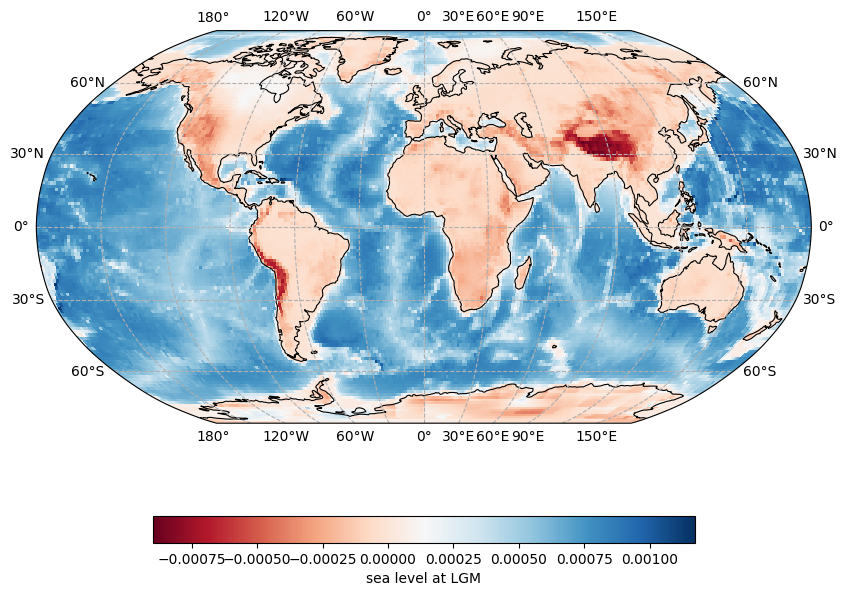

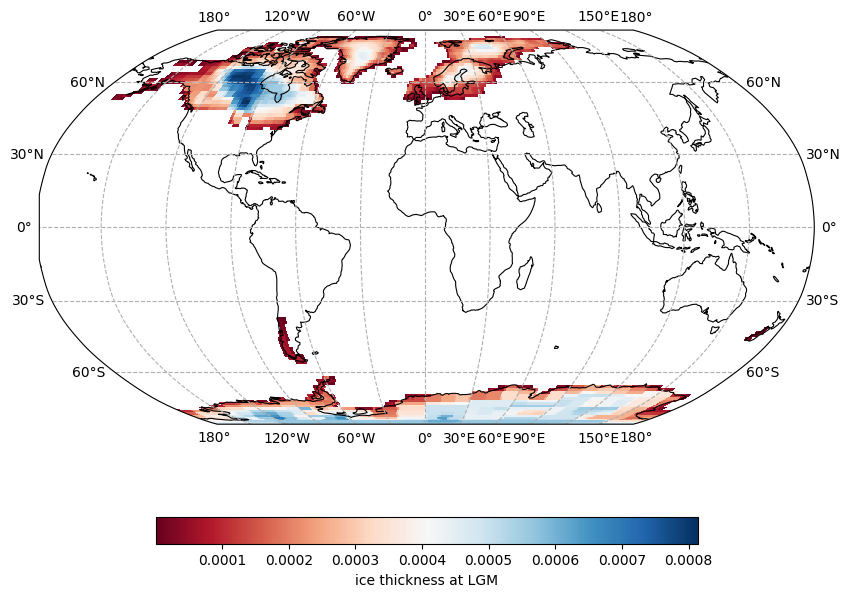

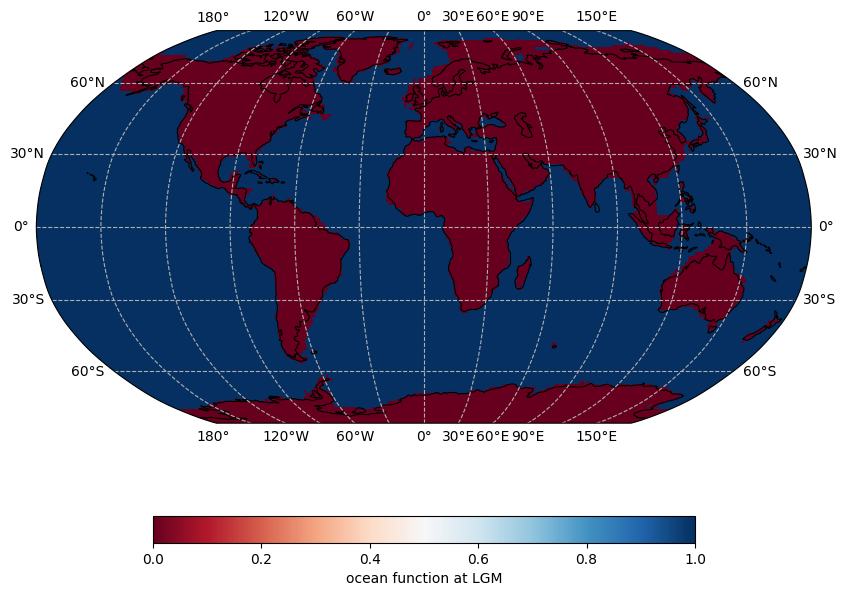

In [6]:
fingerprint.set_state_from_ice_ng(version=5, date=21)

fig, ax, im = fingerprint.plot(fingerprint.sea_level)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink = 0.7, label= "sea level at LGM")

fig, ax, im = fingerprint.plot(fingerprint.ice_thickness, ice_projection=True)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink = 0.7, label= "ice thickness at LGM")

fig, ax, im = fingerprint.plot(fingerprint.ocean_function)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink = 0.7, label= "ocean function at LGM")


plt.show()

The values of ```sea_level``` and ```ice_thickness``` can also be set directly using suitable ```SHGrid``` objects. In the example below we illustrate this idea using a simple one continent world in which the northern hemisphere is all land and the sourthern all ocean. Note that these values need to be set using the chosen non-dimensionalisation scheme.

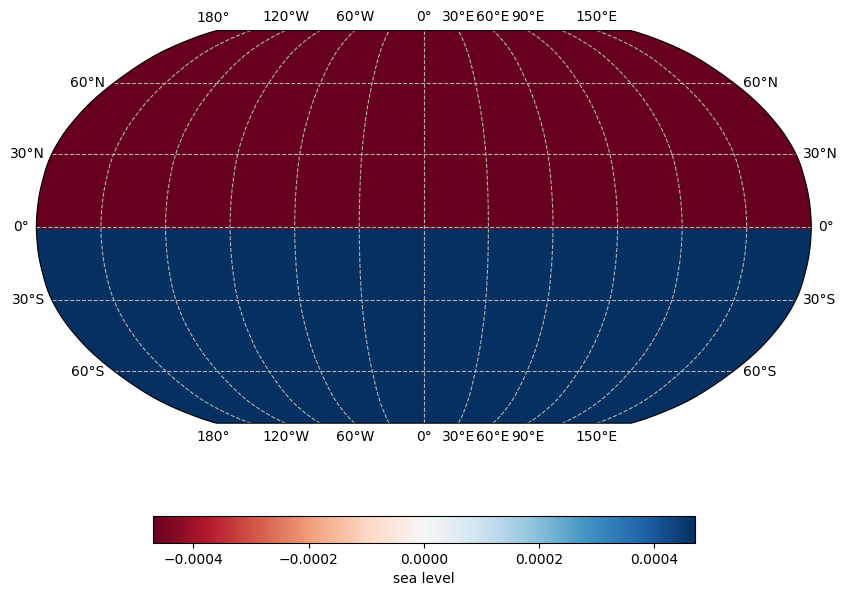

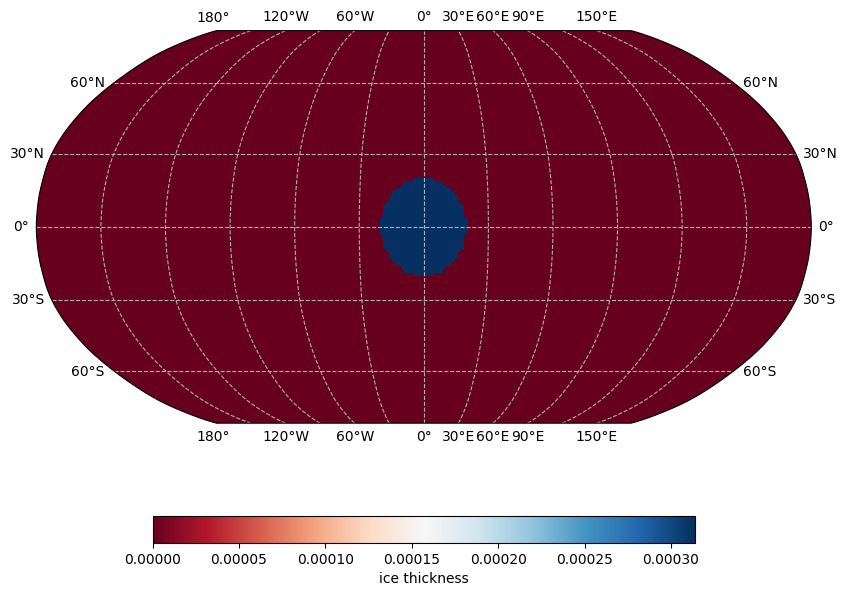

In [7]:

# Generate a numpy array of all latitudes
lats, _ = np.meshgrid(
            fingerprint.lats(),
            fingerprint.lons(),
            indexing="ij",
        )

# Construct the sea level values
sea_level_amplitude = 3000/ fingerprint.length_scale
sea_level = SHGrid.from_array(np.where(lats < 0, sea_level_amplitude, -sea_level_amplitude), grid=fingerprint.grid)


# Now set the ice sheet thickness using a disk geometry.
disk_angular_radius = 20
disk_centre_lat = 0
disk_centre_lon = 0
ice_thickness_amplitude = 2000 / fingerprint.length_scale
ice_thickness = fingerprint.disk_load(disk_angular_radius, disk_centre_lat, disk_centre_lon, ice_thickness_amplitude)

# Set the values and plot the fields. 
fingerprint.sea_level = sea_level
fingerprint.ice_thickness = ice_thickness

# Note coasts are not plotted in these cases. 
fig, ax, im = fingerprint.plot(fingerprint.sea_level, coasts=False)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink = 0.7, label="sea level")

fig, ax, im = fingerprint.plot(fingerprint.ice_thickness,  coasts=False)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink = 0.7, label="ice thickness")

plt.show()





### Step 3 -- Choosing the direct load. 

As previously, within a fingerprint calculation we need to select a direct load. Here we choose to melt 50% of the initial ice sheet. To proceed, we first define the change in ice thickness and then convert this into the associated direct load by setting:
$$
\zeta = \rho_{i}(1-C) \Delta I, 
$$
where $\zeta$ is the direct load, $\rho_{i}$ the density of ice, and $C$ the ocean function. The calculation is done using a method of the ```FingerPrint``` class, but we also show in a comment how it can be done directly. 

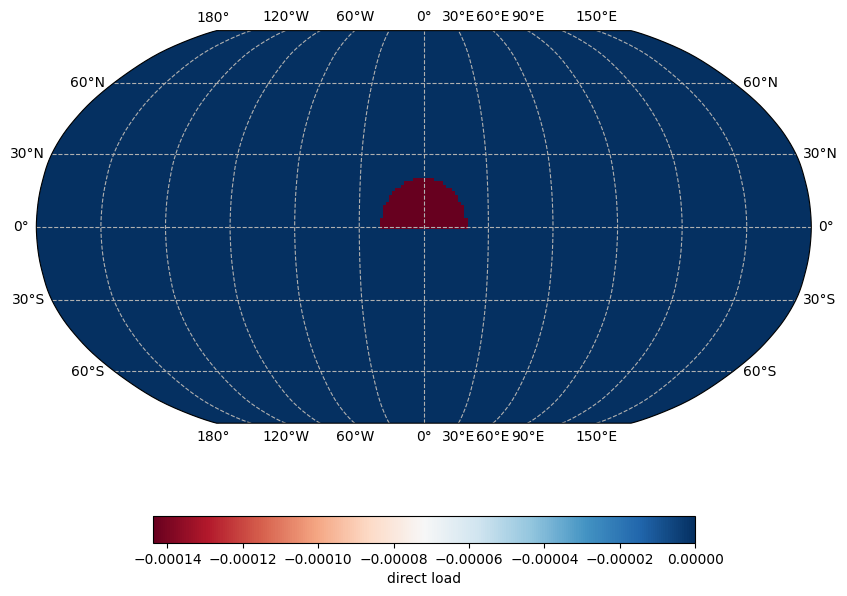

In [8]:
# Set the change in ice_thickness. 
ice_thickness_change = -0.5 * fingerprint.ice_thickness

# Convert to the direct load: 
direct_load = fingerprint.direct_load_from_ice_thickness_change(ice_thickness_change)

# Note that the above method is equivalent to setting:
# direct_load = fingerprint.ice_density * fingerprint.one_minus_ocean_function * ice_thickness_change

fig, ax, im = fingerprint.plot(direct_load, coasts=False)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink = 0.7, label="direct load")

plt.show()

### Step 4 -- Solve the sea level equation

We can now solve the sea level equation to produce the fingerprint. Here we list all keyword arguments for the ```__call__``` method that are relevant to solving standard fingerprint problems:

- ```direct_load```: This is an ```SHGrid``` object specifying the direct load to be used. The default is ```None```
- ```rtol```: Relative tolerance used in the iterative solution of the sea level equation. Default is ```1e-6```.
- ```verbose```: If ```True``` relative errors are printed during the iterative solution. Default is ```False```. 

Four outputs are returned in the following order:
- ```sea_level_change```: An ```SHGrid``` of the change in sea level. 
- ```displacement```: An ```SHGrid``` of the vertical displacement. 
- ```gravity_potential_change```: An ```SHGrid``` of the change in gravity potential.
- ```angular_velocity_change```: A ```numpy``` vector for the change in the angular velocity. Note that only x and y components are returned.

Currently, horizontal displacement cannot be returned by the code, but they are accounted for in the modelling. The component of the angular velocity change along the equilibrium rotation axis is also neglected, and hence only the two horizontal components are returned. This latter approximation is reasonable because the horizontal components are larger by around two orders of magnitude.  



relative angular velocity change [0.00014076 0.        ]


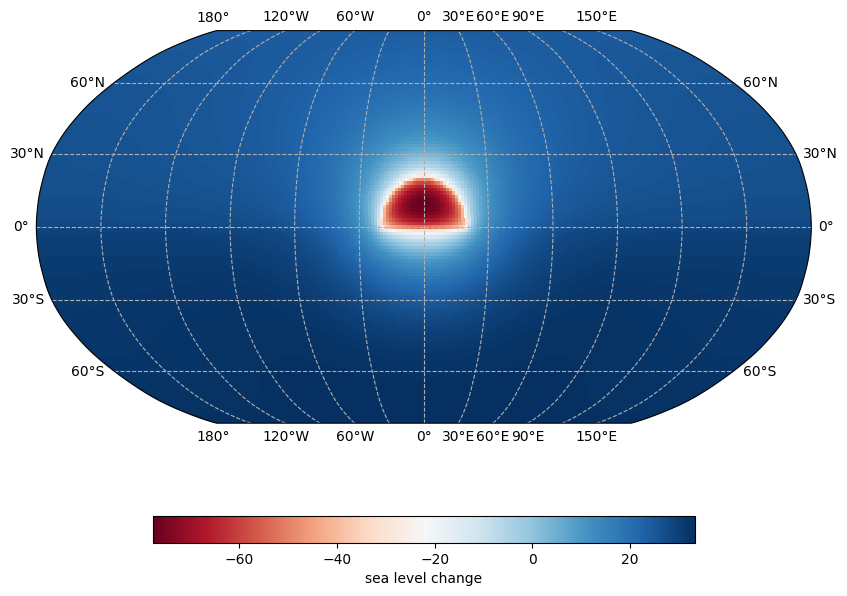

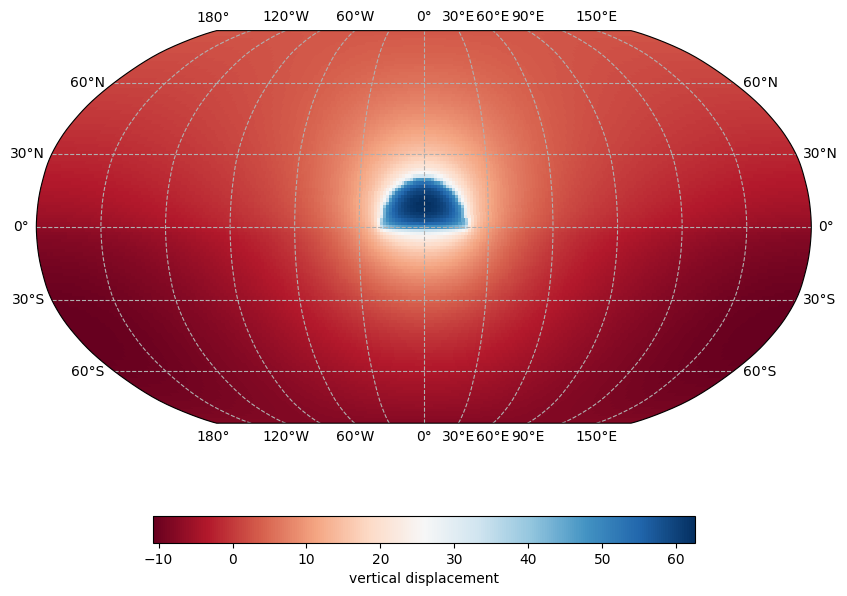

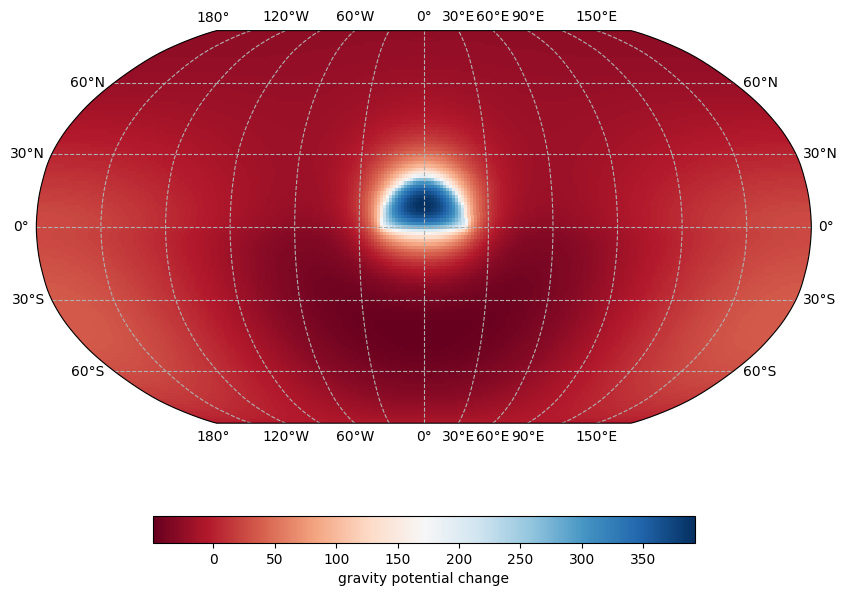

In [9]:
(sea_level_change, displacement, gravity_potential_change, angular_velocity_change) = (
    fingerprint(direct_load=direct_load, rtol=1.0e-9)
)


# Note that the results are dimensionalised before plotting.
fig, ax, im = fingerprint.plot(
    sea_level_change * fingerprint.length_scale, coasts=False
)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.7, label="sea level change")

fig, ax, im = fingerprint.plot(displacement * fingerprint.length_scale, coasts=False)
fig.colorbar(
    im, ax=ax, orientation="horizontal", shrink=0.7, label="vertical displacement"
)

fig, ax, im = fingerprint.plot(
    gravity_potential_change * fingerprint.gravitational_potential_scale, coasts=False
)
fig.colorbar(
    im, ax=ax, orientation="horizontal", shrink=0.7, label="gravity potential change"
)

print(
    f"relative angular velocity change {angular_velocity_change / fingerprint.rotation_frequency}"
)

plt.show()

The gravity potential change, $\gamma$ takes the form
$$
\gamma = \phi + \psi, 
$$  
where $\phi$ is the gravitational potential change and $\psi$ the centrifugal potential change. The latter can be expressed in terms of the angular velocity change, ${\omega}$ through 
$$
\psi = -({\Omega} \times \mathbf{x}) \cdot ({\omega} \times \mathbf{x}), 
$$
where ${\Omega}$ is the equilibrium angular velocity. The gravitational potential change can be recovered from the solution as follows:

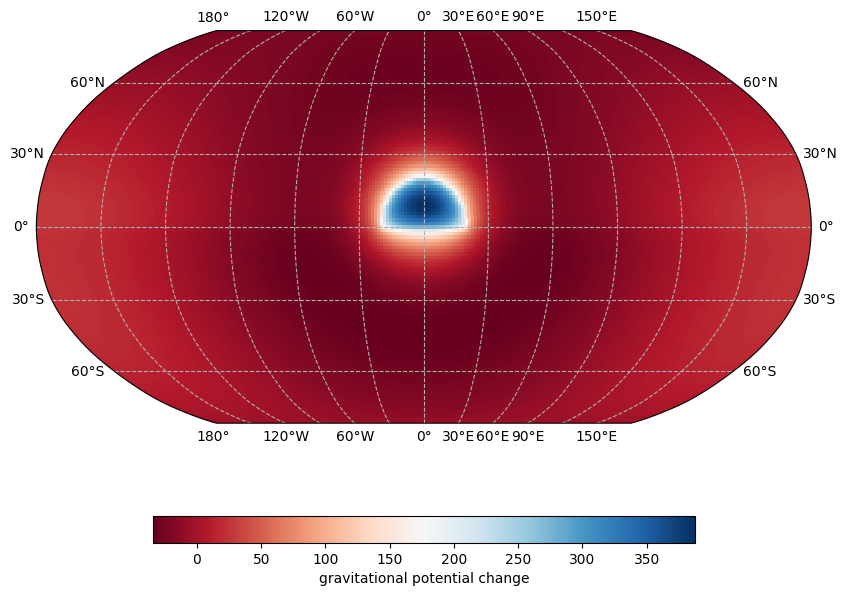

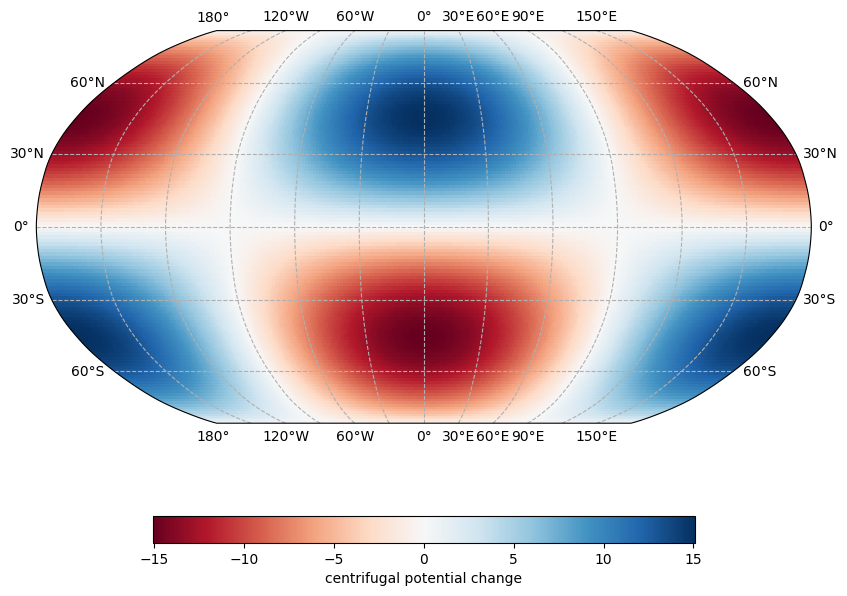

In [10]:
# We can recover the gravitational potential change by subtracting centrifugal contribution.
gravitational_potential_change = (
    fingerprint.gravity_potential_change_to_gravitational_potential_change(
        gravity_potential_change, angular_velocity_change
    )
)


fig, ax, im = fingerprint.plot(
    gravitational_potential_change * fingerprint.gravitational_potential_scale,
    coasts=False,
)
fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    shrink=0.7,
    label="gravitational potential change",
)

# Get the centrifigual potential change
centrifugal_potential_change = gravity_potential_change - gravitational_potential_change

# The above calculation can also be done directly by
# centrifugal_potential_change = fingerprint.centrifugal_potential_change(angular_velocity_change)

fig, ax, im = fingerprint.plot(
    centrifugal_potential_change * fingerprint.gravitational_potential_scale,
    coasts=False,
)
fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    shrink=0.7,
    label="centrifugal potential change",
)

plt.show()
